In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [3]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderBookArrays as job

In [4]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from line_profiler import LineProfiler

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint
import lob.encoding as encoding

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [5]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [6]:
stock = 'GOOG' # 'GOOG', 'INTC'

In [7]:
if stock == 'GOOG':
    ckpt_path = '../checkpoints/treasured-leaf-149_84yhvzjt/' # 0.5 y GOOG, (full model)
elif stock == 'INTC':
    ckpt_path = '../checkpoints/pleasant-cherry-152_i6h5n74c/' # 0.5 y INTC, (full model)

In [8]:
ckpt_path

'../checkpoints/treasured-leaf-149_84yhvzjt/'

In [9]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=32, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=4, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [10]:
# scale down to single GPU, single sample inference
args.bsz = 1 #1, 10
args.num_devices = 1

batchnorm = args.batchnorm

In [11]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [12]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [13]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [14]:
price_levels = 20

In [15]:
import lob.evaluation as eval
from lob.preproc import transform_L2_state

In [16]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

data_levels = 10
sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

n_vol_series = 500  # how many book volume series model uses as input

In [17]:
# entire test set (after training data)

if stock == 'GOOG':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/GOOG/'
elif stock == 'INTC':
    data_dir = '/nfs/home/peern/LOBS5/data/test_set/INTC/'

msg_files = sorted(glob(str(data_dir) + '/*message*.npy'))
book_files = sorted(glob(str(data_dir) + '/*book*.npy'))

ds = LOBSTER_Dataset(
    msg_files,
    n_messages=n_messages + n_eval_messages,
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    seed=42,
    n_cache_files=100,
    randomize_offset=False,
    book_files=book_files,
    use_simple_book=True,
    book_transform=False,
    book_depth=500,
    return_raw_msgs=True,
)

In [18]:
data_dir

'/nfs/home/peern/LOBS5/data/test_set/GOOG/'

In [19]:
ds.book_files

['/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-14_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-15_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-16_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-19_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-20_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-21_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-22_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-23_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-27_34200000_57600000_orderbook_10_proc.npy',
 '/nfs/home/peern/LOBS5/data/test_set/GOOG/GOOG_2022-12-28_34200000_57600000_orderbook_10_p

In [20]:
import chex
chex.clear_trace_counter()

In [27]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [24]:
i = 1234
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

side = 1
quantity = 100
rel_price = 0

rng, rng_ = jax.random.split(rng)

results = inference.generate_impact_rollout(
    side,
    quantity,
    rel_price,
    m_seq,
    b_seq_pv,
    msg_seq_raw,
    book_l2_init,
    seq_len,
    n_messages,
    n_gen_msgs,
    state,
    model,
    batchnorm,
    v.ENCODING,
    rng,
    n_vol_series,
    sim_book_levels,
    sim_queue_len,
    data_levels
)

TypeError: generate_impact_rollout() missing 1 required positional argument: 'data_levels'

In [142]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [31]:
rel_quantity = True  # True: quantity is relative to current book size, False: quantity is absolute

n_samples = 1 # 500
side = 1  # buy
quantity = 0.5  # 100
# rel_price = 10
level = 1  # best ask

save_folder = f'./tmp_impact_{quantity}/'

rng, rng_ = jax.random.split(rng)

inference.study_impact(
    side,
    quantity,
    rel_quantity,
    level,
    n_samples,  # draw n random samples from dataset for evaluation
    ds,
    rng,
    seq_len,
    n_messages,
    n_gen_msgs,
    state,
    model,
    batchnorm,
    v.ENCODING,
    save_folder = save_folder
)

  0%|          | 0/1 [00:00<?, ?it/s]

Processing sample 39112...
[892700    626 892600    290 892800    591 892500    890 892900    990
 892400   1176 893000   2184 892300    952 893100   1288 892200   1172
 893200   2278 892100    947 893300   1127 892000   1251 893400    786
 891900    900 893500    892 891800    350 893600    150 891700    650
     -1      0 891600    401     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
rel quantity: 0.5
ask size 626 bid size 290
rel quantity --> abs: 313
original / ref.d order not found


100%|██████████| 1/1 [01:17<00:00, 77.59s/it]


{'book_losses_l1': Array([[[ 20.65    ,  20.65    ,  28.050001,  38.05    ,  38.05    ,
           43.9     ,  48.9     ,  53.05    ,  47.9     ,  56.55    ,
           71.55    ,  71.55    ,  80.9     ,  80.9     ,  80.9     ,
           85.700005,  83.6     ,  83.6     ,  78.65    ,  93.65    ,
           93.65    , 103.65    , 113.65    , 108.8     , 109.35    ,
           99.85    ,  89.85    , 104.85    , 110.950005, 120.950005,
          116.1     , 131.1     , 131.1     , 130.2     , 140.7     ,
          126.200005, 120.66667 , 126.66667 , 126.90476 , 141.19048 ,
          141.19048 , 140.80952 , 137.85    , 142.6     , 146.7     ,
          161.7     , 152.      , 156.95    , 159.75    , 157.75    ,
          157.95    , 153.3     , 163.3     , 171.90001 , 171.90001 ,
          171.90001 , 171.90001 , 168.1     , 158.1     , 167.8     ,
          169.15001 , 168.55    , 181.65001 , 177.1     , 180.6     ,
          195.6     , 205.75    , 185.75    , 192.40001 , 193.8     ,
  

In [194]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob(f'../data/results/{stock}/inference/*')
tmp_files = glob(f'./tmp_impact/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

In [195]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob(f'../data/results/{stock}/inference/*')
tmp_files = glob(f'./tmp_impact_10/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results_10 = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

In [196]:
# load all tmp files saved during inference and combine to single dict

import pickle

# tmp_files = glob(f'../data/results/{stock}/inference/*')
tmp_files = glob(f'./tmp_impact_500/*')

assert len(tmp_files) > 0, 'no tmp files found'

all_metrics = []
for file in tmp_files:
    with open(file, 'rb') as f:
        sequence_metrics = pickle.load(f)
        all_metrics.append(sequence_metrics)
# combine metrics into single dict
results_500 = {
    metric: jnp.array([d[metric] for d in all_metrics])
    for metric in all_metrics[0].keys()
}

In [179]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

In [ ]:
# for i in range(results['l2_book_states_eval'].shape[0]):
#     print(results['l2_book_states_eval'][i, :4])

In [180]:
results['rets_eval'].shape

(40, 100)

Text(0.5, 1.0, 'Mean Impact Comparison')

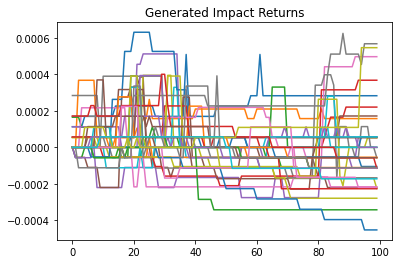

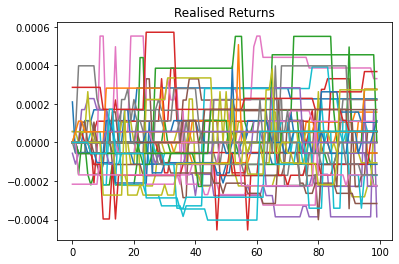

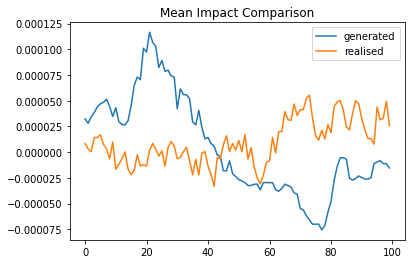

In [188]:
r_gen_df = pd.DataFrame(results['rets_gen'].T)
r_eval_df = pd.DataFrame(results['rets_eval'].T)

r_gen_df.plot()
plt.title('Generated Impact Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

r_eval_df.plot()
plt.title('Realised Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

plt.figure()
r_gen_df.mean(axis=1).plot(label='generated')
r_eval_df.mean(axis=1).plot(label='realised')
plt.legend()
plt.title('Mean Impact Comparison')

Text(0.5, 1.0, 'Mean Impact Comparison')

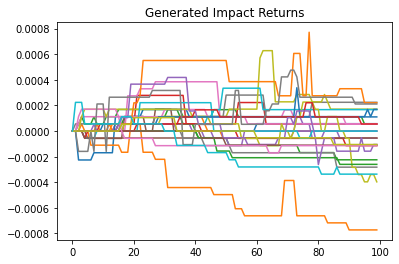

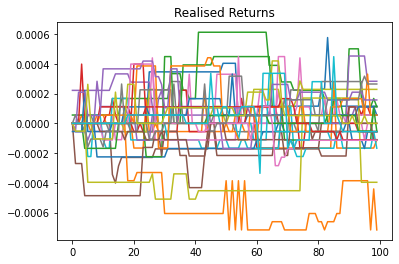

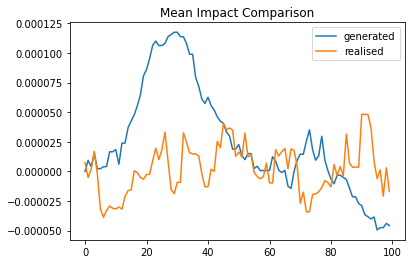

In [189]:
r_gen_df_10 = pd.DataFrame(results_10['rets_gen'].T)
r_eval_df_10 = pd.DataFrame(results_10['rets_eval'].T)

r_gen_df_10.plot()
plt.title('Generated Impact Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

r_eval_df_10.plot()
plt.title('Realised Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

plt.figure()
r_gen_df_10.mean(axis=1).plot(label='generated')
r_eval_df_10.mean(axis=1).plot(label='realised')
plt.legend()
plt.title('Mean Impact Comparison')

Text(0.5, 1.0, 'Mean Impact Comparison')

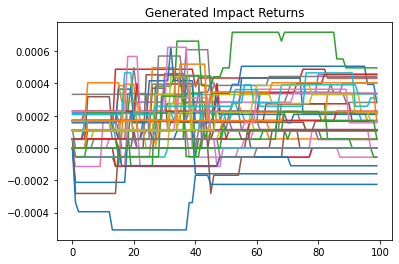

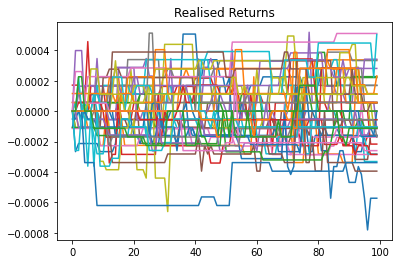

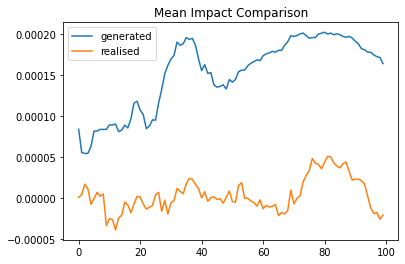

In [197]:
r_gen_df_500 = pd.DataFrame(results_500['rets_gen'].T)
r_eval_df_500 = pd.DataFrame(results_500['rets_eval'].T)

r_gen_df_500.plot()
plt.title('Generated Impact Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

r_eval_df_500.plot()
plt.title('Realised Returns')
# remove legend from current axis
plt.gca().get_legend().remove()

plt.figure()
r_gen_df_500.mean(axis=1).plot(label='generated')
r_eval_df_500.mean(axis=1).plot(label='realised')
plt.legend()
plt.title('Mean Impact Comparison')

In [201]:
dfs = []
for (r_gen, r_eval), q in zip([(r_gen_df_10, r_eval_df_10), (r_gen_df, r_eval_df), (r_gen_df_500, r_eval_df_500)], [10, 100, 500]):

    df_gen = r_gen.iloc[-1:].T
    df_gen.columns = ['return']
    df_gen['type'] = 'generated'
    df_gen['n_gen_msgs'] = 100
    df_gen['quantity'] = q

    df_eval = r_eval.iloc[-1:].T
    df_eval.columns = ['return']
    df_eval['type'] = 'realised'
    df_eval['n_gen_msgs'] = 100
    df_eval['quantity'] = q

    dfs.append(pd.concat([df_gen, df_eval]))

df_impact = pd.concat(dfs)
df_impact

,return,type,n_gen_msgs,quantity
0,0.000058,generated,100,10
1,-0.000055,generated,100,10
2,0.000056,generated,100,10
3,0.000056,generated,100,10
4,-0.000055,generated,100,10
...,...,...,...,...
48,0.000111,realised,100,500
49,-0.000103,realised,100,500
50,-0.000338,realised,100,500
51,0.000056,realised,100,500


<Axes: xlabel='quantity', ylabel='return'>

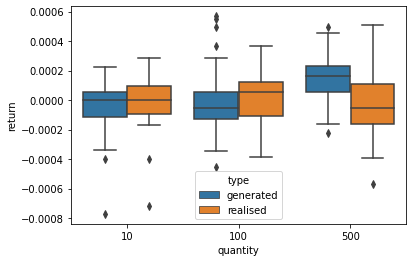

In [202]:
import seaborn as sns

sns.boxplot(x='quantity', y='return', hue='type', data=df_impact)

In [203]:
# TODO:
# compare at n_gen_msgs=10, and 50
# sell side impact
# more samples

df_impact.groupby(['type', 'quantity']).mean()

return  n_gen_msgs
type      quantity                      
generated 10       -0.000046       100.0
          100      -0.000015       100.0
          500       0.000164       100.0
realised  10       -0.000017       100.0
          100       0.000026       100.0
          500      -0.000021       100.0

### Inference evaluation

In [22]:
results.keys()

dict_keys(['book_losses_l1', 'book_losses_l1_const', 'book_losses_wass', 'book_losses_wass_const', 'delta_t_eval', 'delta_t_gen', 'mid_ret_errs', 'mid_ret_errs_const', 'rets_eval', 'rets_gen', 'l2_book_states', 'l2_book_states_eval', 'num_errors', 'event_types_gen', 'event_types_eval', 'raw_msgs_gen', 'raw_msgs_eval'])

[[0.35251    0.5249197  0.09158999]
 [0.3723705  0.5504002  0.10856   ]]


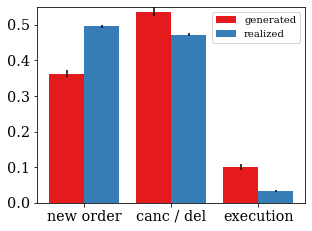

In [29]:
rng, rng_ = jax.random.split(rng)

eval.plot_order_type_frequency(
    results['event_types_gen'],
    results['event_types_eval'],
    rng_,
    combine_mod = True
)
# set y axis limit
plt.ylim(0, 0.55)
plt.savefig(f'../figures/event_types_{stock}.png', dpi=300)

In [59]:
min_x = min(results['delta_t_gen'].min(), results['delta_t_eval'].min())
max_x = max(results['delta_t_gen'].max(), results['delta_t_eval'].max())
min_x, max_x
# GOOG: (Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))
# INTC: 

(Array(1.e-09, dtype=float32), Array(875.4253, dtype=float32))

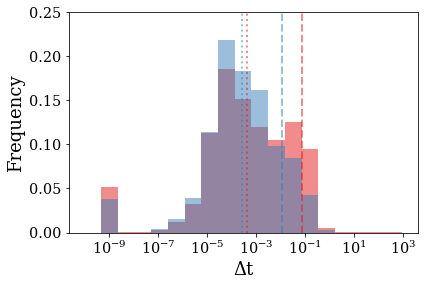

In [61]:
_ = eval.plot_log_hist(results['delta_t_gen'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
_ = eval.plot_log_hist(results['delta_t_eval'].flatten(), add_text=False, min_max=(1.e-10, 875.4253))
# set y axis limit
plt.ylim(0, 0.25)
plt.savefig(f'../figures/time_hist_{stock}.png', dpi=300)

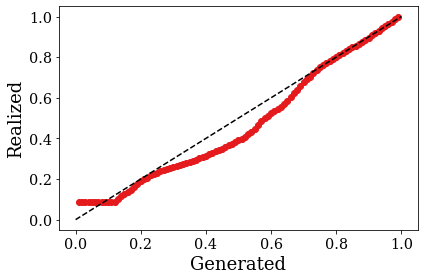

In [284]:
eval.prob_plot_2samples(
    results['delta_t_gen'].flatten(),
    results['delta_t_eval'].flatten()
)
plt.savefig(f'../figures/time_prob_{stock}.png', dpi=300)

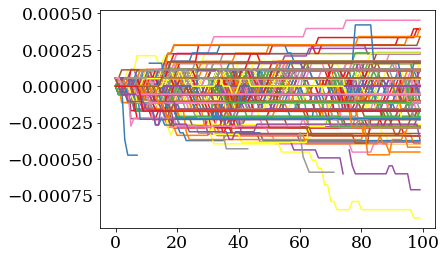

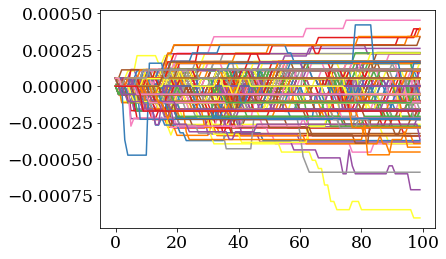

In [51]:
# remove NaNs (temporary empty book side) by forward filling returns

r_gen_df = pd.DataFrame(results['rets_gen'].T)

r_gen_df.plot()
# remove legend from current axis
plt.gca().get_legend().remove()

r_gen_df = r_gen_df.fillna(method='ffill')
r_gen_df.plot()
plt.gca().get_legend().remove()

r_gen = jnp.array(r_gen_df.values).T
r_eval = pd.DataFrame(results['rets_eval'].T).fillna(method='ffill')
r_eval = jnp.array(r_eval.values).T

# remove series starting with NaNs (one empty book side)
r_gen = r_gen[~jnp.isnan(r_eval[:, 0])]  # ... where eval is NaN!
r_eval = r_eval[~jnp.isnan(r_eval[:, 0])]

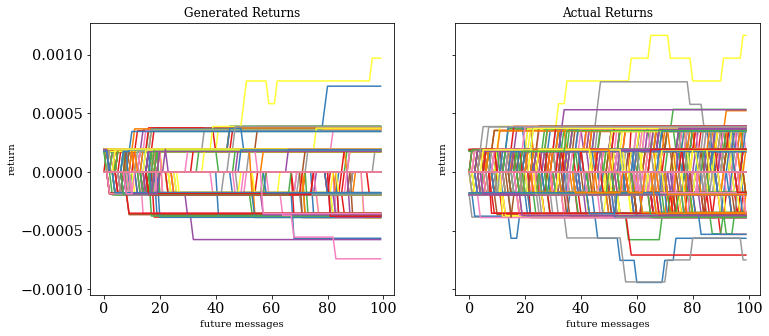

In [286]:
eval.plot_returns(r_gen, r_eval)

In [287]:
results['rets_gen'].shape

(989, 100)

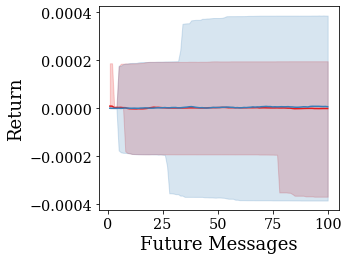

In [288]:
eval.plot_mean_returns(r_gen.T, r_eval.T)
plt.savefig(f'../figures/ret_dist_{stock}.png', dpi=300)

In [73]:
se, percentiles = eval.calc_moments_se(results['rets_gen'], rng)

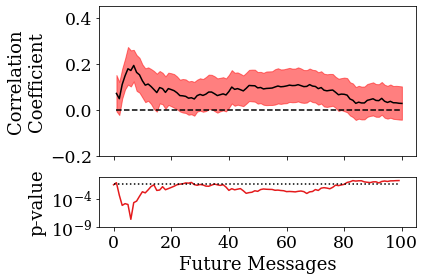

In [52]:
rng, rng_ = jax.random.split(rng)
eval.plot_ret_corr(
    r_gen,
    r_eval,
    ci=0.95,
    ylims=((-0.2, 0.45), (1e-9, 1)),
    rng=rng_
)
plt.savefig(f'../figures/corr_{stock}.png', dpi=300)

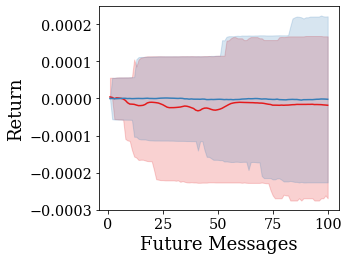

In [240]:
eval.plot_mean_returns(r_gen.T, r_eval.T)

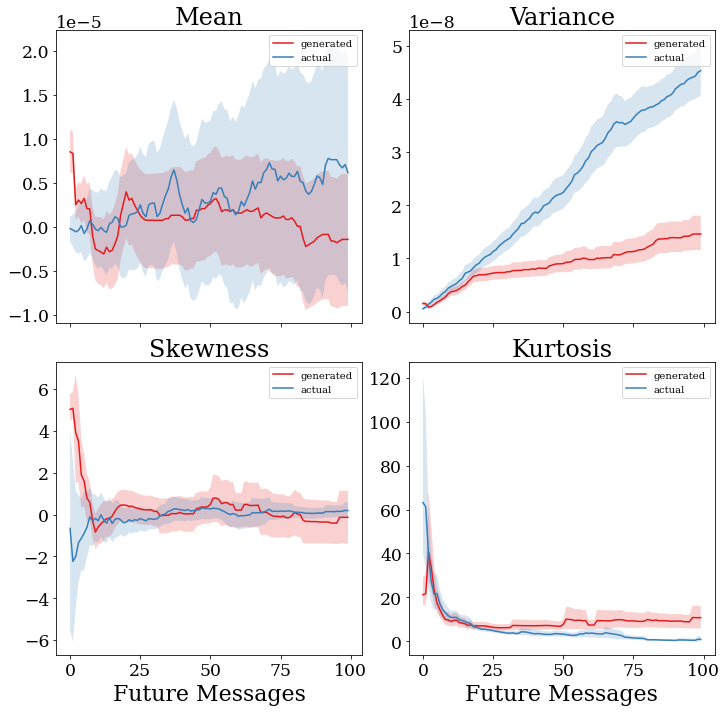

In [290]:
eval.plot_moments(r_gen, r_eval, ci=0.95, rng=rng_)
plt.savefig(f'../figures/moments_{stock}.png', dpi=300)

### DEBUG

In [23]:
ORDER_ID_i = 0
EVENT_TYPE_i = 1
DIRECTION_i = 2
PRICE_ABS_i = 3
PRICE_i = 4
SIZE_i = 5
DTs_i = 6
DTns_i = 7
TIMEs_i = 8
TIMEns_i = 9
PRICE_REF_i = 10
SIZE_REF_i = 11
TIMEs_REF_i = 12
TIMEns_REF_i = 13

In [32]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [34]:
i = 27742
m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[int(i)]

sim_init, _trades = inference.get_sim(
    init_l2_book=book_l2_init,
    replay_msgs_raw=msg_seq_raw[: n_messages],
    sim_book_levels=sim_book_levels,
    sim_queue_len=sim_queue_len,
)

In [35]:
n_levels = 20
bids = sim_init.bids
asks = sim_init.asks


# MAX_INT = 2_147_483_647  # max 32 bit int

# # unique sorts ascending --> negative values to get descending
# bid_prices = -1 * jnp.unique(-1 * bids[:, 0], size=n_levels, fill_value=-1)
# # replace -1 with max 32 bit int in sorting asks before sorting
# ask_prices = jnp.unique(
#     jnp.where(asks[:, 0] == -1, MAX_INT, asks[:, 0]),
#     size=n_levels,
#     fill_value=-1
# )
# # replace max 32 bit int with -1 after sorting
# ask_prices = jnp.where(ask_prices == MAX_INT, -1, ask_prices)

# bids = jnp.stack((bid_prices, job.get_totquant_at_prices(bids, bid_prices)))
# asks = jnp.stack((ask_prices, job.get_totquant_at_prices(asks, ask_prices)))
# bids.T, asks.T

In [27]:
job.get_next_executable_order(1, sim_init.asks)

Array([   890700,        77, 347907322,         0,     40736, 151309962],      dtype=int32)

In [28]:
job.get_next_executable_order(0, sim_init.bids)

Array([   890300,        35, 347875734,         0,     40735, 871994835],      dtype=int32)

In [29]:
job.get_L2_state(asks, bids, n_levels)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [30]:
sim_init.asks.shape

(2000, 6)

In [31]:
sim_init.asks

Array([[   891400,       100, 347756706,         0,     40731, 836124038],
       [   890900,        90, 347772098,         0,     40732, 278549158],
       [   891400,       100, 347812694,         0,     40733, 362540625],
       ...,
       [       -1,        -1,        -1,        -1,        -1,        -1],
       [       -1,        -1,        -1,        -1,        -1,        -1],
       [       -1,        -1,        -1,        -1,        -1,        -1]],      dtype=int32)

In [32]:
job.get_order_by_id(sim_init.asks, 347812694)

Array([   891400,       100, 347812694,         0,     40733, 362540625],      dtype=int32)

In [33]:
sim_init.get_L2_state(n_levels)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [34]:
job.get_L2_state(sim_init.asks, sim_init.bids, 20)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [35]:
sim_init.get_L2_state(20)

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [92]:
a_before = sim_init.asks, sim_init.bids

l2_before = sim_init.get_L2_state(n_levels)
l2_before

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [104]:
side = 1
quantity = 999
rel_price = 100 # make executable

encoder = v.ENCODING

In [105]:
m_seq_raw_inp = msg_seq_raw[: n_messages]

p_mid_old = sim_init.get_L2_state(n_levels)[([0, 2],)].mean().astype(jnp.int32)

event_type = 1  # new limit order
tick_size = 100
new_order_id = 42
time_init_s = m_seq_raw_inp[-1, DTs_i]
time_init_ns = m_seq_raw_inp[-1, DTns_i]
# assume impact message has same timestamp as last message in input sequence
delta_t_s, delta_t_ns = 0, 0
time_s, time_ns = time_init_s, time_init_ns
print('p_mid_old', p_mid_old)
# construct raw impact message
sim_msg, impact_msg, msg_raw = inference.get_sim_msg_new(
    p_mid_old,
    event_type, quantity, side, rel_price, delta_t_s, delta_t_ns, time_s, time_ns,
    new_order_id,
    tick_size,
    encoder,
)

p_mid_old 890500


In [95]:
sim_msg

Array([     1,      1,    999, 900500,      0,     42,      0, 294621],      dtype=int32)

In [96]:
impact_msg

Array([ 1003, 12010, 12008, 11107,  2006,     3,     3,     3,     3,
           3,     3,     3,   297,   624,     2,     2,     2,     2,
           2,     2,     2,     2], dtype=int32)

In [97]:
msg_raw

Array([    42,      1,      1, 900500,    100,    999,      0,      0,
            0, 294621,  -9999,  -9999,  -9999,  -9999], dtype=int32)

In [98]:
_trades = sim_init.process_order_array(sim_msg)
_trades

Array([[   890500,       100,     -9000, 347710702,     40731, 755919404],
       [   890500,       100,     -9000, 347694094,     40731, 756301878],
       [   890500,        74,     -9000, 347693014,     40731, 767385236],
       [   890500,       100,     -9000, 347690994,     40731, 769653831],
       [   890500,       100,     -9000, 347710590,     40731, 836067719],
       [   890600,       100,     -9000, 347728130,     40732, 127822930],
       [   890600,        22,     -9000, 347693310,     40732, 134103260],
       [   890600,        90,     -9000, 347666878,     40732, 275403772],
       [   890900,        10, 347666878, 347772098,     40732, 278549158],
       [   890500,         4, 347772418, 347764602,     40732, 289031697],
       [   891100,        18, 347764602, 347772526,     40732, 289031697],
       [   890500,        38, 347772422, 347735590,     40732, 289076410],
       [   890500,         1, 347772422, 347721438,     40732, 290936618],
       [   890500,       

In [99]:
_trades.shape

(100, 6)

In [103]:
l2_before

Array([890700,    177, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,   1216, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [102]:
sim_init.get_L2_state(n_levels)

Array([890700,    100, 890300,     35, 890800,   1525, 890200,   1051,
       890900,   1255, 890100,    503, 891000,   2415, 890000,   1242,
       891100,   1535, 889900,    750, 891200,   1245, 889800,   1473,
       891300,    780, 889700,    350, 891400,    294, 889600,    856,
           -1,      0, 889500,    271,     -1,      0, 889400,   1300,
           -1,      0, 889300,    496,     -1,      0, 889200,    150,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [ ]:
sim_init.orderbook_array.shape

(2, 20, 100, 6)

In [64]:
m_seq_raw_inp[:31]

Array([[347721814,         3,         1,    889900,        -5,       100,
                0,   5313344,     40731, 633486247,        -5,       100,
            40731, 132656455],
       [347743798,         1,         1,    889800,        -6,       100,
                0,    221053,     40731, 633707300,     -9999,     -9999,
            -9999,     -9999],
       [347743854,         1,         1,    890300,        -1,       100,
                0,   1899085,     40731, 635606385,     -9999,     -9999,
            -9999,     -9999],
       [347743854,         3,         1,    890300,        -1,       100,
                0,  31171769,     40731, 666778154,        -1,       100,
            40731, 635606385],
       [347746026,         1,         1,    890300,        -1,       100,
                0,  15970362,     40731, 682748516,     -9999,     -9999,
            -9999,     -9999],
       [347746026,         3,         1,    890300,        -1,       100,
                0,     48433,  

In [22]:
import logging
# logging.basicConfig(filename='ar_debug.log', level=logging.DEBUG)
fhandler = logging.FileHandler(filename='ar_debug.log', mode='w')
logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.WARNING)

In [36]:
# DEBUG: sim replay

i = 27742

m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[i]
m_seq_raw_inp = msg_seq_raw[: n_messages]
m_seq_raw_eval = msg_seq_raw[n_messages: ]

sim = OrderBook()
# init simulator at the start of the sequence
inference.reset_orderbook(sim, book_l2_init)
# replay sequence in simulator (actual)
# so that sim is at the same state as the model

print('init L2 state')
print(sim.get_L2_state(n_levels))
print('init book data')
print(b_seq_pv[0, 1:21])

for i in range(m_seq_raw_inp.shape[0] - 1):
    print(i)
    replay = inference.msgs_to_jnp(m_seq_raw_inp[i: i+1])
    print(replay)
    print(
        encoding.repr_raw_msg(m_seq_raw_inp[i])
    )

    trades = sim.process_orders_array(replay)
    
    best_bid, best_ask = sim.get_best_bid(), sim.get_best_ask()
    # print('trades:\n', trades)
    print(best_bid, best_ask)
    print(sim.get_L2_state(n_levels))
    if best_bid >= best_ask:
        print("ERROR: CROSSED PRICES")
    print('book data')
    print(b_seq_pv[i+1, 1:21])
        
    print()

    # if i == 30:
        # break

print(sim.asks)
print(sim.bids)

init L2 state
[890500    474 890300    188 890600    212 890200    542 890700    508
 890100    350 890800    974 890000    906 890900    459 889900    650
 891000   1175 889800   1473 891100   1134 889700   1018 891200    845
 889600    556 891300    580 889500    599 891400    878 889400    150
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0
     -1      0     -1      0     -1      0     -1      0     -1      0]
init book data
[890500    474 890300    188 890600    212 890200    542 890700    508
 890100    350 890800    974 890000    906 890900    459 889900    650]
0
[[        3         1       100    889900         0 347721814     40731
  633486247]]
OID:	347721814
event_type:	3
direction:	1
price_abs:	889900
price:	-5
size:	100
delta_t_s:	0
delta_t_ns:	5313344
time_s:	40731
time_ns:	633486247
p_ref:	-5
size_ref:	100
t

In [135]:
sim.asks

Array([[890500,    374,  -9000,      0,  34200,      0],
       [890600,    212,  -9000,      0,  34200,      0],
       [890700,    508,  -9000,      0,  34200,      0],
       [890800,    974,  -9000,      0,  34200,      0],
       [890900,    459,  -9000,      0,  34200,      0],
       [891000,   1175,  -9000,      0,  34200,      0],
       [891100,   1134,  -9000,      0,  34200,      0],
       [891200,    845,  -9000,      0,  34200,      0],
       [891300,    580,  -9000,      0,  34200,      0],
       [891400,    878,  -9000,      0,  34200,      0],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,     -1,     -1,     -1],
       [    -1,     -1,     -1,

In [134]:
job.get_init_volume_at_price(sim.asks, 891100)

Array(1134, dtype=int32)

In [122]:
orderside = sim_init.asks

oid_match = (orderside[:, 2] == 347710702)
idx = jnp.where(oid_match, size=1, fill_value=-1)[0][0]
idx

Array(-1, dtype=int32)

In [123]:
# msg = jnp.array([3,-1,100,891100,0, 347710702,40731,755919404])

msg = {
    'price': 891100,
    'orderid': 347710702,
    'quantity': 100,
}

In [130]:
job.cancel_order(orderside, msg)[:10]

Array([[   891400,       100, 347756706,         0,     40731, 836124038],
       [   890900,        90, 347772098,         0,     40732, 278549158],
       [   891400,       100, 347812694,         0,     40733, 362540625],
       [   890800,       974,     -9000,         0,     34200,         0],
       [   890900,       459,     -9000,         0,     34200,         0],
       [   891000,      1175,     -9000,         0,     34200,         0],
       [   891100,      1034,     -9000,         0,     34200,         0],
       [   891200,       845,     -9000,         0,     34200,         0],
       [   891300,       580,     -9000,         0,     34200,         0],
       [   891400,       878,     -9000,         0,     34200,         0]],      dtype=int32)

In [105]:
init_id_match = ((orderside[:, 0] == 891100) & (orderside[:, 2] <= -9000))
idx = jnp.where(init_id_match, size=1, fill_value=-1)[0][0]
idx

Array(6, dtype=int32)

In [106]:
idx

Array(6, dtype=int32)

In [107]:
orderside[idx]

Array([891100,   1134,  -9000,      0,  34200,      0], dtype=int32)

In [118]:
sim.get_volume_at_price(1, 890300)

Array(0, dtype=int32)